In [1]:
from transformers import LlavaForConditionalGeneration, AutoProcessor
import torch
from peft import peft_model,PeftModel

/home/ZJH/miniconda3/envs/mote/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_model_name_or_path = "show_model_v1/model001"
peft_model_name_or_path = "output_model_user_lora_show"
model = LlavaForConditionalGeneration.from_pretrained(raw_model_name_or_path,device_map="cuda:0", torch_dtype=torch.bfloat16)
model = PeftModel.from_pretrained(model, peft_model_name_or_path, adapter_name="peft_v1")
processor = AutoProcessor.from_pretrained(raw_model_name_or_path)
if not hasattr(processor.image_processor, 'patch_size') or processor.image_processor.patch_size is None:
    print("正在应用 patch_size 补丁...")
    processor.image_processor.patch_size = 14
    if hasattr(processor, "patch_size"):
        processor.patch_size = 14
model.eval()
print('ok')

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


正在应用 patch_size 补丁...
ok


In [3]:
from show_llava.data import LlavaDataset

llavadataset = LlavaDataset("data/LLaVA-CC3M")
len(llavadataset), llavadataset[10]

(595375,
 ('<image>\nProvide a brief description of the given image.',
  'organization is synonymous with azaleas .',
  PosixPath('data/LLaVA-CC3M/images_dl/GCC_train_000177248.jpg')))

In [4]:
testdata = llavadataset[1234]
testdata

('<image>\nGive a short and clear explanation of the subsequent image.',
 'plastic swing at the playground in the autumn city park',
 PosixPath('data/LLaVA-CC3M/images_dl/GCC_train_000971262.jpg'))

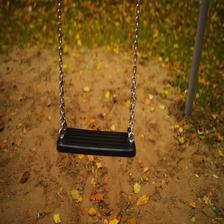

In [5]:
from PIL import Image
Image.open(testdata[2])

In [6]:
# 因为配置文件没保存 patch_size，推理时必须手动再次指定，
# 否则 processor 不知道把 <image> 展开成多少个 token。
if not hasattr(processor.image_processor, 'patch_size') or processor.image_processor.patch_size is None:
    processor.image_processor.patch_size = 14

if not hasattr(processor, 'patch_size') or processor.patch_size is None:
    processor.patch_size = 14

In [7]:
def build_model_input(model, processor, testdata: tuple):
    # ================= 核心逻辑：手动展开 =================
    # 1. 计算需要的 Token 数量
    # LLaVA 使用 CLIP-336px, Patch Size=14
    # (336 / 14) * (336 / 14) = 24 * 24 = 576
    num_image_tokens = 575
    
    # 2. 构造“巨型”占位符字符串
    # 这会生成一串长得像 "<image><image>...<image>" 的字符串
    image_token_str = "<image>" * num_image_tokens
    
    # 3. 构造 Prompt
    # 注意：这里我们不再依赖模板自动加图片token，而是把我们生成好的长字符串塞进去
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": image_token_str + "\n" + testdata[0]}, 
    ]
    
    # 4. 应用模板
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # ====================================================

    # 5. 加载图片
    image = Image.open(testdata[2])
    
    # 6. 处理输入
    # 这里的关键是：prompt 里已经包含了 576 个 <image> 字符串
    # 哪怕 processor 不知道 patch_size，它也会乖乖把这 576 个串变成 576 个 ID
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    
    # 7. 移动到显卡
    for tk in inputs.keys():
        inputs[tk] = inputs[tk].to(model.device)
        
    # 8. 生成
    print("开始生成...")
    with torch.no_grad():
        generate_ids = model.generate(**inputs, max_new_tokens=50)
    
    # 9. 解码
    generate_ids = [
        oid[len(iids):] for oid, iids in zip(generate_ids, inputs.input_ids)
    ]

    gen_text = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    return gen_text

# --- 再次调用 ---
print("正在推理...")
# 确保你的 testdata 格式是 (问题, 答案, 图片路径)
res = build_model_input(model, processor, testdata)
print("="*20)
print("Result:", res)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


正在推理...
开始生成...
Result: a swing in the park
